In [122]:
import re
from datetime import datetime
import pandas as pd
import ipywidgets as widgets
from IPython import display


# get ts and temp 
SSD_TEMP_FILES = ['hw/smartctl.txt']
TIME_REG = '2022-[(0-9)]+-[(0-9)]+-[(0-9)]+-[(0-9)]+-[(0-9)]+'
DEVICE_MODEL = 'Device Model:'
SERIAL_NUMBER = 'Serial Number:'
TEMP_REG = '194 Temperature_Celsius'

data = {'dt': [], 'temp': [], 'device model': [], 'serial number': []}
for file in SSD_TEMP_FILES:
    with open(file) as f:
        while True:
            line = f.readline()
            if not line:
                break
            line = line.strip()
            t = re.match(TIME_REG, line)
            if t:
                dt = datetime.strptime(line, '%Y-%m-%d-%H-%M-%S')
                data['dt'].append(pd.Timestamp(dt.strftime('%Y-%m-%d %H:%M:%S')))
            t = re.match(DEVICE_MODEL, line)
            if t:
                patten = line.split(':')
                data['device model'].append(f'{patten[1].strip()}')
            t = re.match(SERIAL_NUMBER, line)
            if t:
                patten = line.split(':')

                data['serial number'].append(f'{patten[1].strip()}')
            t = re.match(TEMP_REG, line)
            if t:
                patten = line.split('-')
                patten = patten[1].strip().split('(')
                data['temp'].append(float(patten[0].strip()))
df = pd.DataFrame(data=data)
widget1 = widgets.Output()
display.display(df.head(10))
print('finished')

,dt,temp,device model,serial number
0,2022-11-25 02:50:38,30.0,CT2000MX500SSD1,2227E645D963
1,2022-11-25 02:50:38,31.0,CT2000MX500SSD1,2227E645D6EE
2,2022-11-25 02:52:25,26.0,CT2000MX500SSD1,2227E645D963
3,2022-11-25 02:52:25,30.0,CT2000MX500SSD1,2227E645D6EE
4,2022-11-25 02:52:30,26.0,CT2000MX500SSD1,2227E645D963
5,2022-11-25 02:52:30,31.0,CT2000MX500SSD1,2227E645D6EE
6,2022-11-25 02:52:36,26.0,CT2000MX500SSD1,2227E645D963
7,2022-11-25 02:52:36,31.0,CT2000MX500SSD1,2227E645D6EE
8,2022-11-25 02:52:41,26.0,CT2000MX500SSD1,2227E645D963
9,2022-11-25 02:52:41,31.0,CT2000MX500SSD1,2227E645D6EE


finished


In [130]:
import os
import math
from typing import List
import matplotlib.pyplot as plt
FIO_RESULT_PATHS = ['test_results']
                    
DIFF_SECOND = 5

data2 = {'dt': [], 'type': [], 'rw': [], 'iops': [], 'bw': [], 'dt_ssda': [], 'temp_ssda': [],'dt_ssdb': [], 'temp_ssdb': []}

tests = [
    'rand_rw_aio',
    'rand_w_aio',
    'w_aio',
    'rw_aio',
    'rand_rw_psync',
    'rand_w_psync',
    'rw_psync',
    'w_psync'
]

test_results = [k for k in tests]

for path in FIO_RESULT_PATHS:
    dir_list = os.listdir(path)
    for d in dir_list:
        dt = datetime.strptime(d, '%Y-%m-%d-%H-%M-%S')
        if True:
            all_tested = True
            for test in tests:
                try:
                    with open(os.path.join(f'{path}/{d}', f'fio_{test}.txt')) as f:
                        pass
                except Exception as ex:
                    all_tested = False
            if all_tested is True:
                for test in tests:
                    with open(os.path.join(f'{path}/{d}', f'fio_{test}.txt')) as f:
                        while True:
                            line = f.readline()
                            if not line:
                                break
                            line = line.strip()
                            if 'IOPS' in line:
                                pdt = pd.Timestamp(dt.strftime('%Y-%m-%d %H:%M:%S'))

                                rw = line.split(':')[0]
                                iops = line.split(':')[1].split(',')[0].split('IOPS=')[1].strip()
                                if 'k' in iops:
                                    iops = float(iops.split('k')[0]) * pow(1024, 1)
                                else:
                                    iops = float(iops)
                                bw = line.split(':')[1].split(',')[1].split(' (')[0].split('BW=')[1].split('/s')[0].strip()
                                if 'KiB' in bw:
                                    bw = float(bw.split('KiB')[0]) * pow(1024, 1)
                                elif 'MiB' in bw:
                                    bw = float(bw.split('MiB')[0]) * pow(1024, 2)
                                else:
                                    bw = float(bw)

                                df_ssda = df[(df.dt < pdt + pd.Timedelta(f'0 days 00:00:0{DIFF_SECOND}')) & \
                                            (df.dt > pdt - pd.Timedelta(f'0 days 00:00:0{DIFF_SECOND}')) & \
                                            (df['serial number'] == '2227E645D963')]
                                df_ssdb = df[(df.dt < pdt + pd.Timedelta(f'0 days 00:00:0{DIFF_SECOND}')) & \
                                            (df.dt > pdt - pd.Timedelta(f'0 days 00:00:0{DIFF_SECOND}')) & \
                                            (df['serial number'] == '2227E645D6EE')]
                                if df_ssda.size != 0 and df_ssdb.size != 0 :
                                    data2['type'].append(test)
                                    data2['dt'].append(pdt)
                                    data2['iops'].append(iops)
                                    data2['bw'].append(bw)
                                    data2['rw'].append(rw)
                                    data2['dt_ssda'].append(df_ssda['dt'].values[0])
                                    data2['temp_ssda'].append(df_ssda['temp'].values[0])
                                    data2['dt_ssdb'].append(df_ssdb['dt'].values[0])
                                    data2['temp_ssdb'].append(df_ssdb['temp'].values[0])
                                else:
                                    print('not found', pdt)

df2 = pd.DataFrame(data=data2)
widget2 = widgets.Output()
df2 = df2.sort_values(by=['dt']) # TODO use index
display.display(df2.head(10))
df2.to_csv('data.csv')
print('finished')

not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14
not found 2022-11-30 09:29:14


,dt,type,rw,iops,bw,dt_ssda,temp_ssda,dt_ssdb,temp_ssdb
0,2022-11-25 02:52:28,rand_rw_aio,read,39424.0,157286400.0,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
11,2022-11-25 02:52:28,w_psync,write,14233.6,56937676.8,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
10,2022-11-25 02:52:28,rw_psync,write,4860.0,18874368.0,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
9,2022-11-25 02:52:28,rw_psync,read,4890.0,20027801.6,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
7,2022-11-25 02:52:28,rand_rw_psync,write,4376.0,17930649.6,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
6,2022-11-25 02:52:28,rand_rw_psync,read,4404.0,18035507.2,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
8,2022-11-25 02:52:28,rand_w_psync,write,9510.0,39007027.2,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
4,2022-11-25 02:52:28,rw_aio,read,43724.8,175112192.0,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
3,2022-11-25 02:52:28,w_aio,write,100556.8,402653184.0,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0
2,2022-11-25 02:52:28,rand_w_aio,write,65228.8,261095424.0,2022-11-25 02:52:25,26.0,2022-11-25 02:52:25,30.0


finished


'w_aio, 2022/11/25 02:50 +8:00, temp: 35°C'

,iops,bw,temp_ssda,temp_ssdb
count,4.000000,4.000000e+00,4.000000,4.000000
mean,103475.200000,4.136632e+08,28.750000,35.000000
std,2425.388909,8.582964e+06,2.217356,3.559026
min,100556.800000,4.026532e+08,26.000000,30.000000
25%,101939.200000,4.089446e+08,27.500000,33.750000
50%,103936.000000,4.157604e+08,29.000000,36.000000
75%,105472.000000,4.204790e+08,30.250000,37.250000
max,105472.000000,4.204790e+08,31.000000,38.000000


'w_aio, 2022/11/29 17:00 +8:00, temp: 50°C'

,iops,bw,temp_ssda,temp_ssdb
count,31.000000,3.100000e+01,31.000000,31.000000
mean,102238.141935,4.091476e+08,53.483871,54.580645
std,2477.963520,9.672773e+06,0.995690,0.992445
min,92262.400000,3.690988e+08,49.000000,50.000000
25%,101529.600000,4.057989e+08,53.000000,54.500000
50%,102400.000000,4.110418e+08,54.000000,55.000000
75%,103936.000000,4.152361e+08,54.000000,55.000000
max,105472.000000,4.215276e+08,54.000000,55.000000


'w_aio, 2022/11/30 10:25 +8:00, temp: 60°C'

,iops,bw,temp_ssda,temp_ssdb
count,14.000000,1.400000e+01,14.000000,14.000000
mean,102334.171429,4.093191e+08,62.714286,63.500000
std,1390.534310,5.403468e+06,0.611250,0.650444
min,100454.400000,4.016046e+08,61.000000,62.000000
25%,101273.600000,4.050125e+08,63.000000,63.000000
50%,102297.600000,4.094689e+08,63.000000,64.000000
75%,103424.000000,4.131389e+08,63.000000,64.000000
max,105472.000000,4.215276e+08,63.000000,64.000000


'w_aio, 2022/11/30 14:45 +8:00, temp: 65°C'

,iops,bw,temp_ssda,temp_ssdb
count,5.000000,5.000000e+00,5.000000,5.000000
mean,66293.760000,2.659189e+08,67.800000,67.600000
std,1452.853567,5.771932e+06,0.447214,0.547723
min,64819.200000,2.589983e+08,67.000000,67.000000
25%,65536.000000,2.631926e+08,68.000000,67.000000
50%,65843.200000,2.663383e+08,68.000000,68.000000
75%,66662.400000,2.663383e+08,68.000000,68.000000
max,68608.000000,2.747269e+08,68.000000,68.000000


'w_aio, 2022/11/30 17:30 +8:00, temp: 0°C'

,iops,bw,temp_ssda,temp_ssdb
count,28.000000,2.800000e+01,28.000000,28.000000
mean,101602.742857,4.065853e+08,3.285714,5.071429
std,2207.586300,8.687304e+06,0.534522,0.262265
min,92262.400000,3.690988e+08,3.000000,5.000000
25%,101324.800000,4.052746e+08,3.000000,5.000000
50%,101990.400000,4.078961e+08,3.000000,5.000000
75%,102400.000000,4.102554e+08,3.250000,5.000000
max,104448.000000,4.194304e+08,5.000000,6.000000


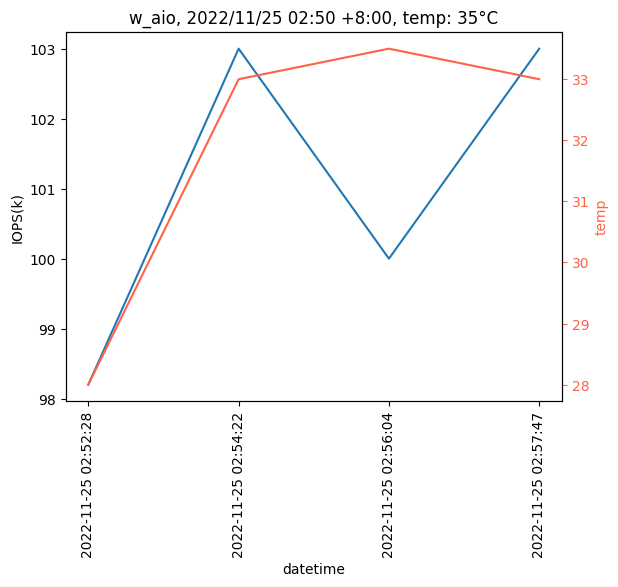

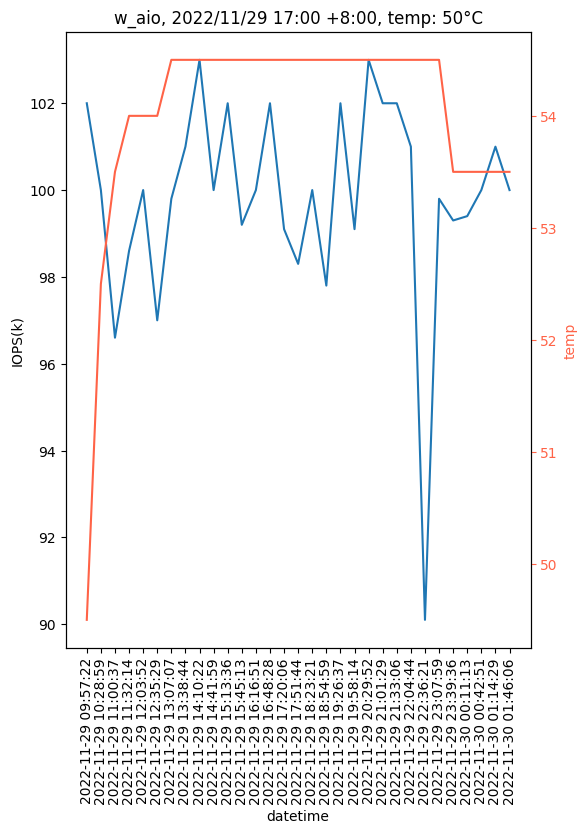

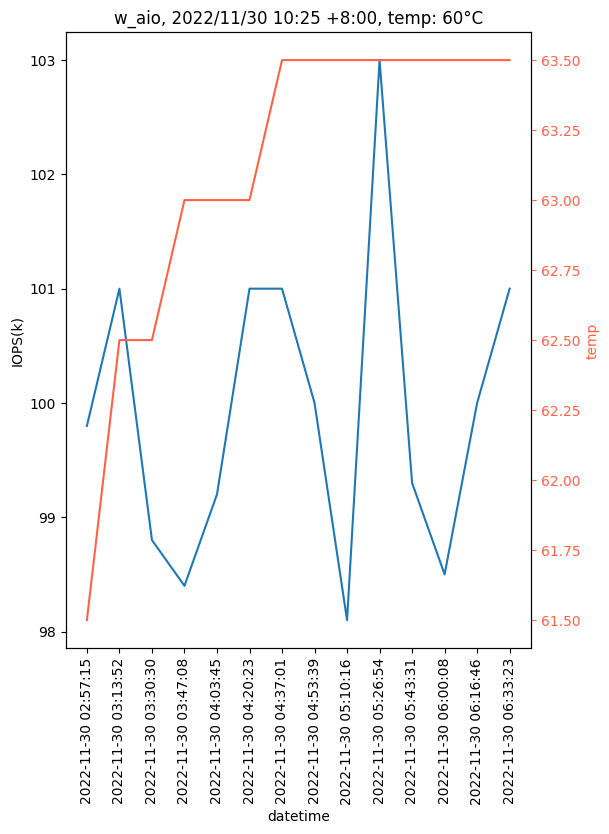

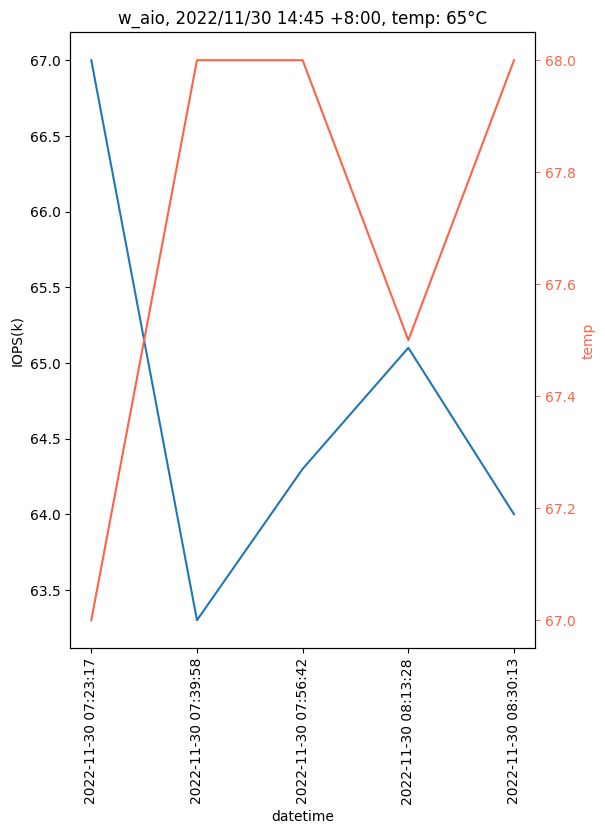

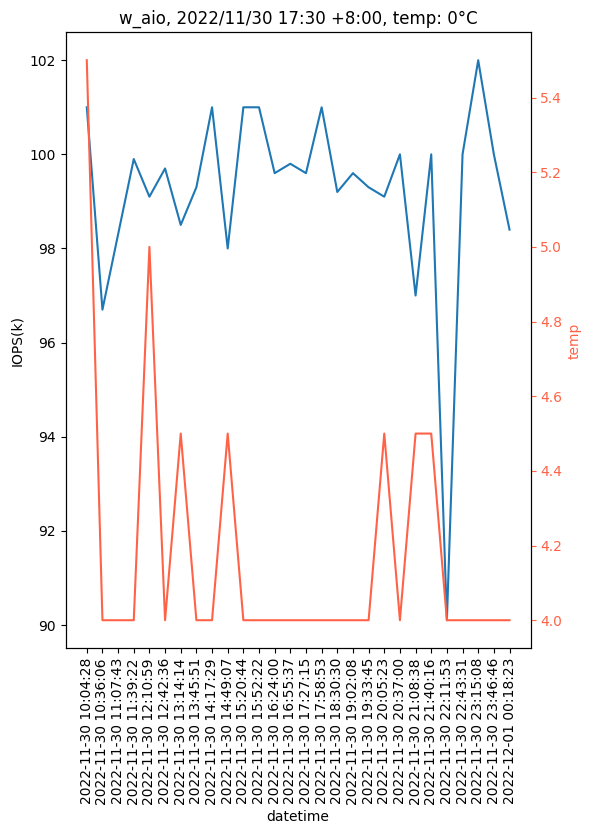

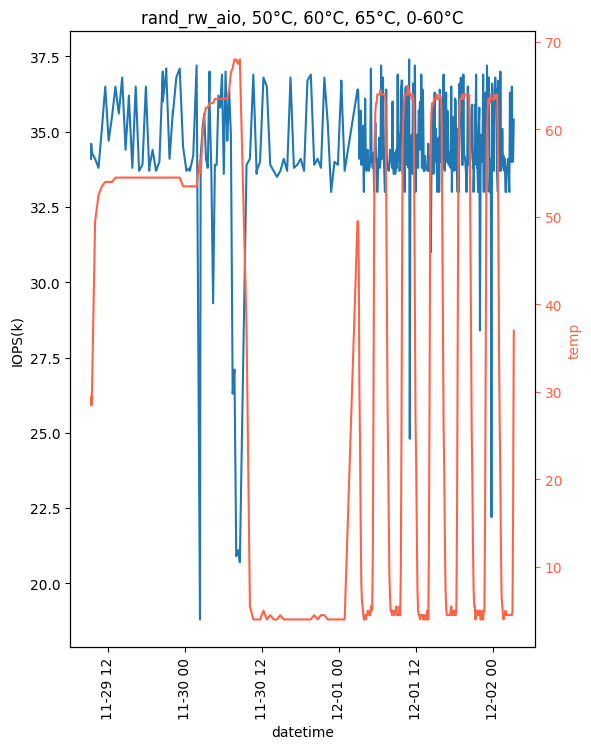

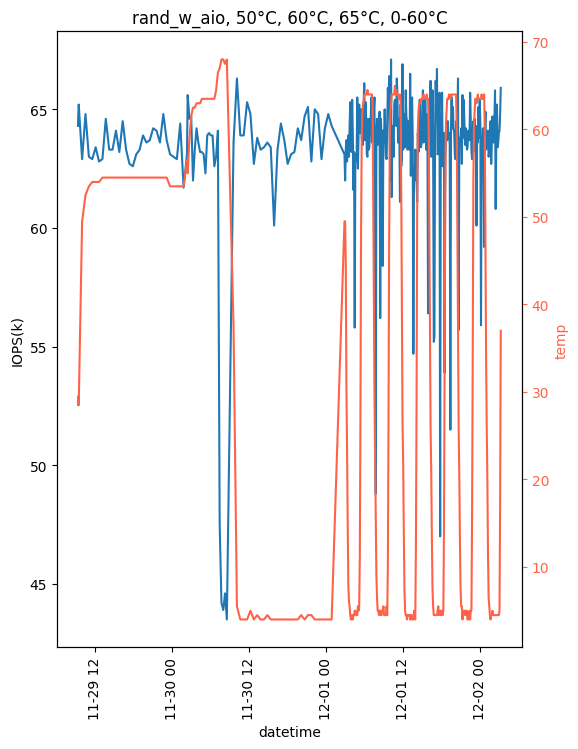

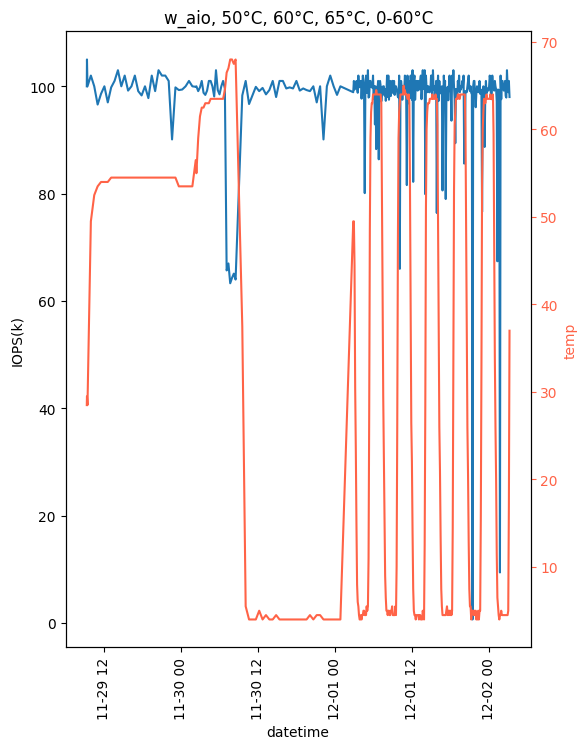

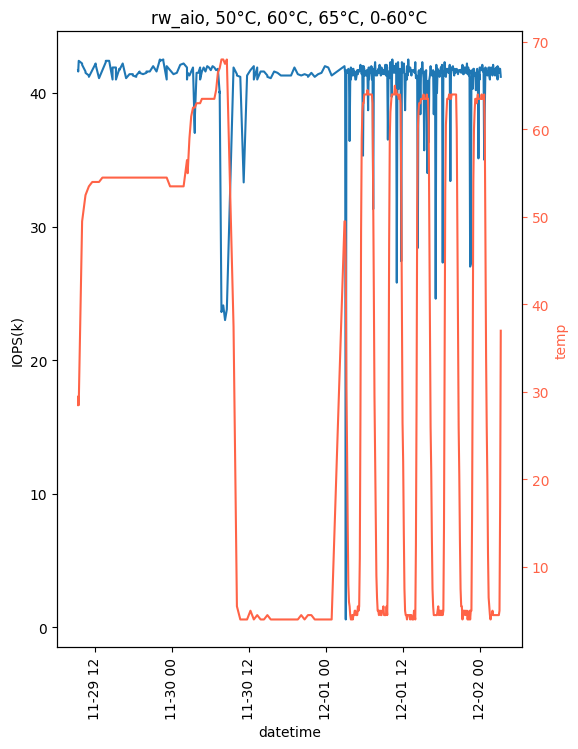

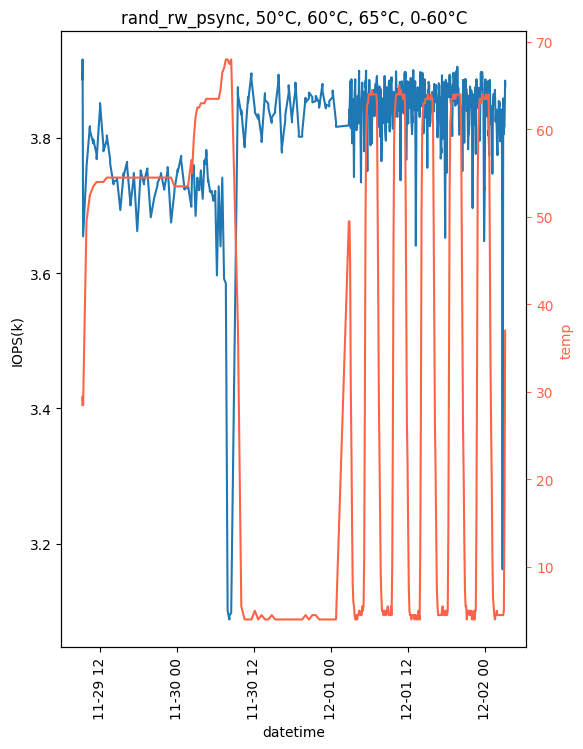

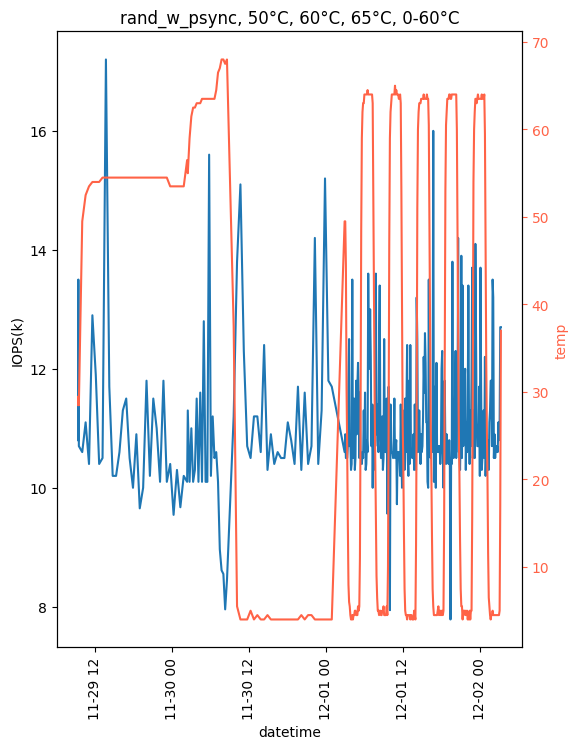

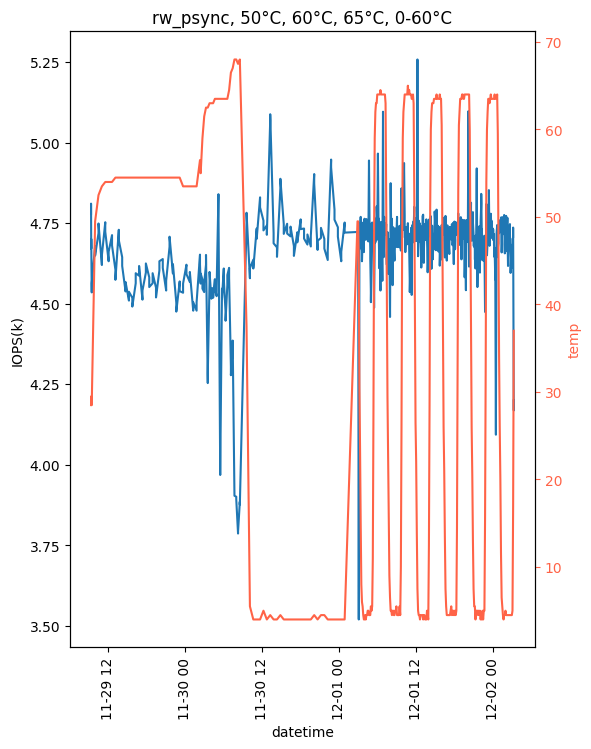

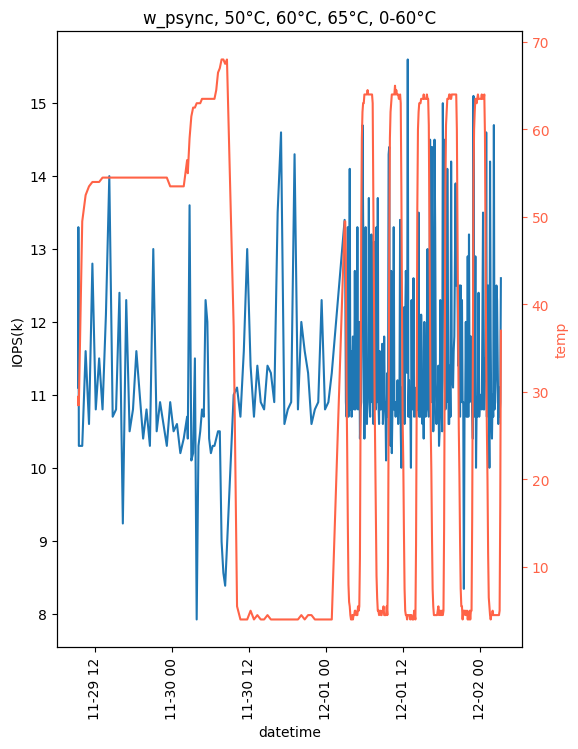

<Figure size 600x800 with 0 Axes>

In [131]:
%matplotlib inline

class Result:
    def __init__(self, title, df):
        self.title = title
        self.df = df

results = []

timerange = [
    ['2022/11/25 02:50 +8:00, temp: 35°C', '2022-11-25 02:50:00', '2022-11-25 03:10:00'],
    ['2022/11/29 17:00 +8:00, temp: 50°C', '2022-11-29 09:50:00', '2022-11-30 02:00:00'],
    ['2022/11/30 10:25 +8:00, temp: 60°C', '2022-11-30 02:55:00', '2022-11-30 06:40:00'],
    ['2022/11/30 14:45 +8:00, temp: 65°C', '2022-11-30 07:20:00', '2022-11-30 09:32:00'],
    ['2022/11/30 17:30 +8:00, temp: 0°C', '2022-11-30 10:00:00', '2022-12-01 00:50:00'],
    ['50°C, 60°C, 65°C, 0-60°C', '2022-11-29 09:00:00', '2022-12-02 03:30:00'],
]
widget3 = widgets.Output()


for i in range(len(timerange)):
    df3 = df2[(df2.dt > pd.Timestamp(timerange[i][1])) & \
              (df2.dt < pd.Timestamp(timerange[i][2]))]
    results.append(Result(timerange[i][0], df3))


for i in range(len(results)):
    for k in test_results:
        x = []
        y = []
        z = []
        xlabel = 'datetime'
        ylabel = 'IOPS(k)'
        df3 = results[i].df
        df_d1 = df3[df3.type == k]
        is_draw = False
        is_display = False
        for _, row in df_d1.iterrows():
            if results[i].title != '50°C, 60°C, 65°C, 0-60°C':
                x.append(row['dt'].strftime('%Y-%m-%d %H:%M:%S'))
                if k == 'w_aio':
                    is_draw = True
                    is_display = True
            else:
                is_draw = True
                x.append(pd.to_datetime(row['dt'], unit='ms', origin='unix'))
            y.append(row['iops'] / 1024)
            z.append((row['temp_ssda'] + row['temp_ssdb']) / 2)

        if is_display is True:
            display.display(f'{k}, {results[i].title}', df_d1.describe())
        if is_draw is True:
            plt.plot(x, y)
            plt.title(f'{k}, {results[i].title}')
            plt.xlabel(xlabel)
            plt.xticks(rotation=90)
            plt.ylabel(ylabel)
            ax2 = plt.gca().twinx()
            ax2.plot(x, z, 'tomato')
            ax2.tick_params(colors='tomato', which='both')  # 'both' refers to minor and major axes
            plt.ylabel('temp', color='tomato')
            plt.figure(figsize=(6, 8))

    #     plt.show()
